Text(0, 0.5, 'Radar Altimeter')

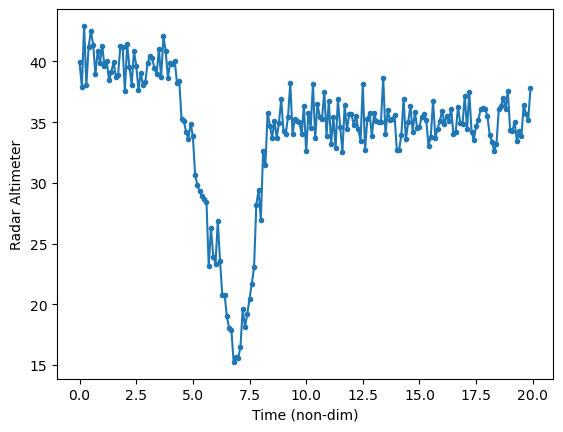

In [3]:
import pymc as pm
import terrain.csv as terrain
import numpy as np 
import arviz as az
import scipy
import matplotlib.pyplot as plt
import pytensor.tensor as at


h0 = 45.0
v0 = 3.5
t0 = 0.0
tf = 20.0
x0 = 15.5
#
# rvs
tau = 0.5
time_error = scipy.stats.norm(loc=0, scale=0.001 )
alt_error = scipy.stats.norm( loc=0, scale=1/np.sqrt(tau) ) 
# generate simulated measurements
t_true=  np.arange( start=t0 ,stop=tf , step=0.1)
t_measured = t_true #+ time_error.rvs( size= len(t_true) ) 
x_measured = x0 + v0 * t_measured
#s = sim.Map_1D( "1dim.csv")
a_true =  h0 - terrain.data.sample( x_measured )
a_measured = a_true + alt_error.rvs( size=len(a_true))

plt.figure(1)
plt.plot( t_measured , a_measured , marker="." )
plt.xlabel("Time (non-dim)")
plt.ylabel("Radar Altimeter")


In [4]:

def altimeter( H0: at.TensorVariable, T: at.TensorVariable, Tau: at.TensorVariable, size: at.TensorVariable ) -> at.TensorVariable:
    M = H0-T
    return pm.Normal.dist( M , tau=Tau, size=size)
with pm.Model() as uPriors:
    # associate data with model (this makes prediction easier)
    H_data = pm.Data("Hm", a_measured, mutable=False)
    T_data = pm.Data("Tm", t_measured, mutable=True )
    # priors - uniform giving equal weight to all possible locations and velocities in range
    X0 = pm.Uniform("x0", lower=10, upper=40)  #pm.Uniform("x0", lower=10, upper=40) # pm.Normal( "X0" , mu=35, sigma=3)
    H0 = pm.Uniform("h0", lower=40, upper=60) # pm.Normal( "H0", mu=40, sigma=5 )
    V0 = pm.Uniform("v0", lower=1, upper=4)
    Tau = pm.Gamma( "Tau", alpha=5, beta=1)
    # X position through the terrain 
    X = X0 + (V0 * T_data)
    T = terrain.terrain_alt( X )
    #
    A = pm.CustomDist( "Alt" ,  H0 ,T,Tau, dist=altimeter , observed=H_data)
    #
    # start sampling
    trace = pm.sample(10000)


Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>CompoundStep
>>Slice: [x0]
>>Slice: [v0]
>NUTS: [h0, Tau]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 21 seconds.
c:\Users\Purdu\anaconda3\Lib\site-packages\arviz\utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


In [5]:
az.summary( trace )

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
x0,15.468,0.415,14.672,16.226,0.016,0.012,645.0,1336.0,1.0
h0,45.008,0.105,44.811,45.202,0.002,0.001,3652.0,11306.0,1.0
v0,3.507,0.060,3.399,3.625,0.002,0.002,645.0,1334.0,1.0
Tau,0.555,0.054,0.453,0.657,0.000,0.000,38970.0,28037.0,1.0


c:\Users\Purdu\anaconda3\Lib\site-packages\arviz\utils.py:185: NumbaDeprecationWarning: The keyword argument 'nopython=False' was supplied. From Numba 0.59.0 the default is being changed to True and use of 'nopython=False' will raise a warning as the argument will have no effect. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


array([<Axes: title={'center': 'x0'}>, <Axes: title={'center': 'h0'}>,
       <Axes: title={'center': 'v0'}>, <Axes: title={'center': 'Tau'}>],
      dtype=object)

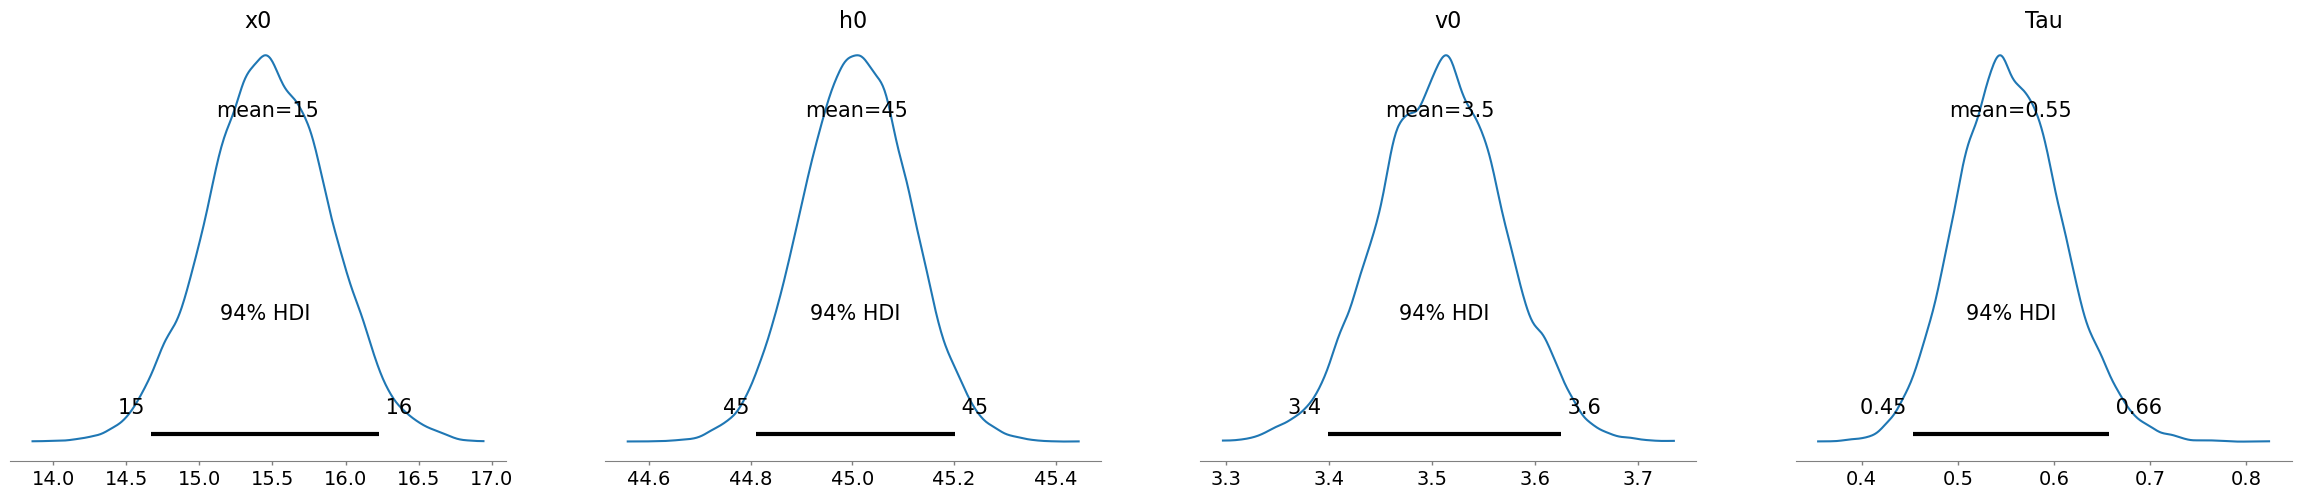

In [6]:
az.plot_posterior( trace)